# Homework 1 - Data Wrangling with Hadoop

The goal of this assignment is to put into action the data wrangling techniques from the exercises of week-3 and week-4. We highly suggest you to finish these two exercises first and then start the homework. In this homework, we are going to reuse the same __sbb__ dataset as we see in two exercises. 

Try to use as much as HiveQL as possible and use pandas operations only when it's necessary.
   
__Hand-in:__
- __Due: 24.03.2020 23:59 CET__
- `git push` your final verion to your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your queries readable


__Cluster Usage__

As there are many of you working with the cluster, we encourage you to prototype your queries on small data samples before running them on whole datasets.

__Documentation__

Hive queries: <https://cwiki.apache.org/confluence/display/Hive/LanguageManual+Select>

Hive functions: <https://cwiki.apache.org/confluence/display/Hive/LanguageManual+UDF>


In [1]:
import os
import pandas as pd
pd.set_option("display.max_columns", 50)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from pyhive import hive
import numpy as np

username = os.environ['JUPYTERHUB_USER']
# create connection
conn = hive.connect(host='iccluster059.iccluster.epfl.ch', port=10000, username=username) 
# create cursor
cur = conn.cursor()

## Data from SBB/CFF/FFS

Data source: <https://opentransportdata.swiss/en/dataset/istdaten>

In this part, you will leverage Hive to perform exploratory analysis of data published by the [Open Data Platform Swiss Public Transport](https://opentransportdata.swiss).

Format: the dataset is originally presented as a collection of textfiles with fields separated by ';' (semi-colon). For efficiency, the textfiles have been compressed into Optimized Row Columnar ([ORC](https://cwiki.apache.org/confluence/display/Hive/LanguageManual+ORC)) file format. 

Location: you can find the data in ORC format on HDFS at the path `/data/sbb/orc/istdaten`.

The full description from opentransportdata.swiss can be found in <https://opentransportdata.swiss/de/cookbook/ist-daten/> in four languages. Because of the translation typos there may be some misunderstandings. We suggest you rely on the German version and use an automated translator when necessary. We will clarify if there is still anything unclear in class and Slack. Here are the relevant column descriptions:

- `BETRIEBSTAG`: date of the trip
- `FAHRT_BEZEICHNER`: identifies the trip
- `BETREIBER_ABK`, `BETREIBER_NAME`: operator (name will contain the full name, e.g. Schweizerische Bundesbahnen for SBB)
- `PRODUKT_ID`: type of transport, e.g. train, bus
- `LINIEN_ID`: for trains, this is the train number
- `LINIEN_TEXT`,`VERKEHRSMITTEL_TEXT`: for trains, the service type (IC, IR, RE, etc.)
- `ZUSATZFAHRT_TF`: boolean, true if this is an additional trip (not part of the regular schedule)
- `FAELLT_AUS_TF`: boolean, true if this trip failed (cancelled or not completed)
- `HALTESTELLEN_NAME`: name of the stop
- `ANKUNFTSZEIT`: arrival time at the stop according to schedule
- `AN_PROGNOSE`: actual arrival time
- `AN_PROGNOSE_STATUS`: show how the actual arrival time is calcluated
- `ABFAHRTSZEIT`: departure time at the stop according to schedule
- `AB_PROGNOSE`: actual departure time
- `AB_PROGNOSE_STATUS`: show how the actual departure time is calcluated
- `DURCHFAHRT_TF`: boolean, true if the transport does not stop there

Each line of the file represents a stop and contains arrival and departure times. When the stop is the start or end of a journey, the corresponding columns will be empty (`ANKUNFTSZEIT`/`ABFAHRTSZEIT`).

In some cases, the actual times were not measured so the `AN_PROGNOSE_STATUS`/`AB_PROGNOSE_STATUS` will be empty or set to `PROGNOSE` and `AN_PROGNOSE`/`AB_PROGNOSE` will be empty.

### Question I.a - 5 Points

In the exercise, you were asked to find how many stops of each type of transportation for the date 05.11.2018. Now, let's do the same for the whole dataset. 

Show the results with a stacked bar chart (you can use `pandas` to create a pivot table if necessary). Document any patterns you can see.

__Hint__: 
- To properly order by date, you may have to parse them using the `unix_timestamp` function.
- When using `pd.read_sql(query, conn, ...)` to retrieve the query results, there is one `parse_dates` argument for date parsing.
- If you think it is not nice to display all the data in one plot, you can select a small period of data, i.e. 3 months, for visualization to detect the pattern.

In [2]:
# Drop your database
query = """
    drop database if exists {0} cascade
""".format(username)
cur.execute(query)

# Create your database
query = """
    create database {0} location "/user/{0}/hive"
""".format(username)
cur.execute(query)

# Drop the sbb table
query = """
    drop table if exists {0}.sbb_orc
""".format(username)
cur.execute(query)

# Create the sbb table
query = """
    create external table {0}.sbb_orc(
        BETRIEBSTAG string,
        FAHRT_BEZEICHNER string,
        BETREIBER_ID string,
        BETREIBER_ABK string,
        BETREIBER_NAME string,
        PRODUKT_ID string,
        LINIEN_ID string,
        LINIEN_TEXT string,
        UMLAUF_ID string,
        VERKEHRSMITTEL_TEXT string,
        ZUSATZFAHRT_TF string,
        FAELLT_AUS_TF string,
        BPUIC string,
        HALTESTELLEN_NAME string,
        ANKUNFTSZEIT string,
        AN_PROGNOSE string,
        AN_PROGNOSE_STATUS string,
        ABFAHRTSZEIT string,
        AB_PROGNOSE string,
        AB_PROGNOSE_STATUS string,
        DURCHFAHRT_TF string
    )
    row format delimited fields terminated by ';'
    stored as ORC
    location '/data/sbb/orc/istdaten'
    tblproperties ("skip.header.line.count"="1")
""".format(username)
cur.execute(query)

# Show 3 rows of created sbb table
query = """
    select * 
    from {0}.sbb_orc
    limit 3
""".format(username)
pd.read_sql(query, conn)

,sbb_orc.betriebstag,sbb_orc.fahrt_bezeichner,sbb_orc.betreiber_id,sbb_orc.betreiber_abk,sbb_orc.betreiber_name,sbb_orc.produkt_id,sbb_orc.linien_id,sbb_orc.linien_text,sbb_orc.umlauf_id,sbb_orc.verkehrsmittel_text,sbb_orc.zusatzfahrt_tf,sbb_orc.faellt_aus_tf,sbb_orc.bpuic,sbb_orc.haltestellen_name,sbb_orc.ankunftszeit,sbb_orc.an_prognose,sbb_orc.an_prognose_status,sbb_orc.abfahrtszeit,sbb_orc.ab_prognose,sbb_orc.ab_prognose_status,sbb_orc.durchfahrt_tf
0,29.11.2019,80:06____:17012:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17012,RE,,RE,false,false,8500090,Basel Bad Bf,,,PROGNOSE,29.11.2019 06:34,,UNBEKANNT,false
1,29.11.2019,80:06____:17013:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17013,RE,,RE,false,false,8500090,Basel Bad Bf,29.11.2019 06:25,,UNBEKANNT,,,PROGNOSE,false
2,29.11.2019,80:06____:17014:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17014,RE,,RE,false,false,8500090,Basel Bad Bf,,,PROGNOSE,29.11.2019 09:48,,UNBEKANNT,false


In [ ]:
# Extract number of stops of each transportation type, for december 2018
query = """
    select lower(PRODUKT_ID) as ttype, 
        count(*) as stops, 
        unix_timestamp(BETRIEBSTAG, 'dd.MM.yyyy') as dates
    from {0}.sbb_orc
    where 
        YEAR(TO_DATE(FROM_UNIXTIME(unix_timestamp(BETRIEBSTAG, 'dd.MM.yyyy')))) like '2018' and
        MONTH(TO_DATE(FROM_UNIXTIME(unix_timestamp(BETRIEBSTAG, 'dd.MM.yyyy')))) like '12'
    group by lower(PRODUKT_ID), unix_timestamp(BETRIEBSTAG, 'dd.MM.yyyy')
    order by dates asc
""".format(username)
df_tstops18 = pd.read_sql(query, conn, parse_dates='dates')

In [ ]:
# Extract number of stops of each transportation type, for december 2019
query = """
    select lower(PRODUKT_ID) as ttype, 
        count(*) as stops, 
        unix_timestamp(BETRIEBSTAG, 'dd.MM.yyyy') as dates
    from {0}.sbb_orc
    where 
        YEAR(TO_DATE(FROM_UNIXTIME(unix_timestamp(BETRIEBSTAG, 'dd.MM.yyyy')))) like '2019' and
        MONTH(TO_DATE(FROM_UNIXTIME(unix_timestamp(BETRIEBSTAG, 'dd.MM.yyyy')))) like '12'
    group by lower(PRODUKT_ID), unix_timestamp(BETRIEBSTAG, 'dd.MM.yyyy')
    order by dates asc
""".format(username)
df_tstops19 = pd.read_sql(query, conn, parse_dates='dates')

In [61]:
# Merge the two december dataframes into one
df_tstops = pd.concat([df_tstops18, df_tstops19])
df_tstops.replace([''], 'unknown', inplace=True)
df_tstops.dates = df_tstops.dates.astype(str)

<function matplotlib.pyplot.show(*args, **kw)>

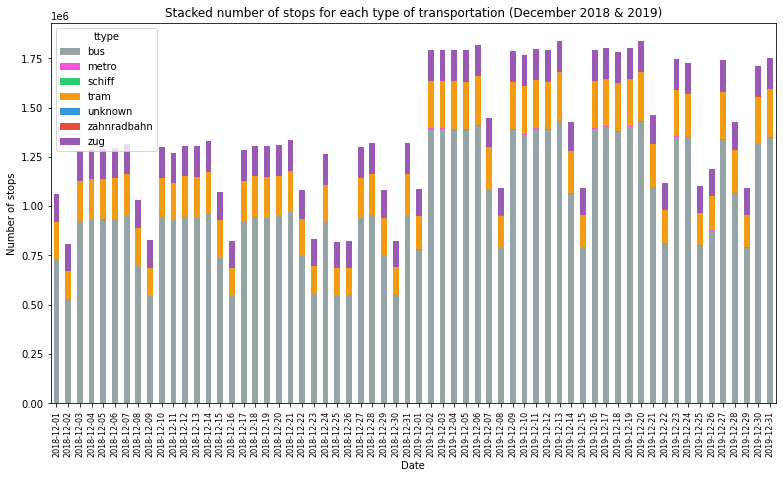

In [77]:
# Create pivot table and plot the results in a stacked bar chart
pivot_df = df_tstops.pivot(index='dates', columns='ttype', values='stops')
pivot_df.plot.bar(stacked=True,
    color=['#95A5A6', '#F655DB', '#2ECC71', '#F39C12', '#3498DB', '#E74C3C', '#9B59B6'], 
    figsize=(13,7), rot=90)
plt.title('Stacked number of stops for each type of transportation (December 2018 & 2019)')
plt.ylabel('Number of stops')
plt.xlabel('Date')
plt.xticks(fontsize=8)
plt.show

**Observation:** *The plot shows that the sbb traffic increased from 2018 to 2019.
The trafic types: bus, tram and zug; are the most common transportation types.
It is possible to see a general pattern with holidays vs. weekdays where there is less transportation on holidays in comparison to weekdays.*

### Question I.b - 10 Points

Get the set of IC (`VERKEHRSMITTEL_TEXT`) trains you can take to go (without connections) from Genève to Lausanne on a typical week day (not Saturday, not Sunday, not a bank holiday). Display the train number (`LINIEN_ID`) as well as the schedule of the trains.

__Note:__ do not hesitate to create intermediary tables. You can use the advanced search of SBB's website to check your answer, the schedule of IC from Genève to Lausanne has not changed.

In [70]:
# Drop table if exists
query = """
    drop table if exists {0}.sbb_geneve
""".format(username)
cur.execute(query)

# Create a table for IC trains in Geneva for a week day (e.g. 05/11/2019)
query = """
    create table {0}.sbb_geneve
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where VERKEHRSMITTEL_TEXT like 'IC' 
        and HALTESTELLEN_NAME like 'Genève' 
        and BETRIEBSTAG like '05.11.2019'
""".format(username)
cur.execute(query)

# Drop table if exists
query = """
    drop table if exists {0}.sbb_Lausanne
""".format(username)
cur.execute(query)

# Create a table for IC trains in Lausanne for a week day (e.g. 05/11/2019)
query = """
    create table {0}.sbb_Lausanne
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where VERKEHRSMITTEL_TEXT like 'IC' 
        and HALTESTELLEN_NAME like 'Lausanne' 
        and BETRIEBSTAG like '05.11.2019'
""".format(username)
cur.execute(query)

In [71]:
# Select relevant parameters from Geneva table and do an outer join with the train ID's
# Filter for trains from Geneva to Lausanne by the prognosed departure/arrival times 
query = """
    select 
        upper(g.VERKEHRSMITTEL_TEXT) as trains, 
        g.LINIEN_ID as id, 
        unix_timestamp(g.AB_PROGNOSE, 'dd.MM.yyy HH:mm') as departure_time_g,
        unix_timestamp(l.AN_PROGNOSE, 'dd.MM.yyy HH:mm') as arrival_time_l  
    from {0}.sbb_geneve g FULL OUTER JOIN {0}.sbb_Lausanne l ON (g.LINIEN_ID = l.LINIEN_ID)
    where 
        unix_timestamp(l.AN_PROGNOSE, 'dd.MM.yyy HH:mm') > 0 and 
        unix_timestamp(g.AB_PROGNOSE, 'dd.MM.yyy HH:mm') > 0 and 
        unix_timestamp(l.AN_PROGNOSE, 'dd.MM.yyy HH:mm') > unix_timestamp(g.AB_PROGNOSE, 'dd.MM.yyy HH:mm')
""".format(username)
df_g_l = pd.read_sql(query, conn)
df_g_l.head(3)

,trains,id,departure_time_g,arrival_time_l
0,IC,707,1572932580,1572934680
1,IC,709,1572936360,1572938460
2,IC,711,1572939780,1572942180


In [72]:
# Use correct date and time format and sort dataframe
df_g_l['departure_time_g'] = df_g_l['departure_time_g']\
    .map(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df_g_l['arrival_time_l'] = df_g_l['arrival_time_l']\
    .map(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df_g_l = df_g_l.sort_values(by='departure_time_g')

print('IC-trains without connections from Geneva to Lausanne, on a typical weekday:')
df_g_l

IC-trains without connections from Geneva to Lausanne, on a typical weekday:


,trains,id,departure_time_g,arrival_time_l
0,IC,707,2019-11-05 05:43:00,2019-11-05 06:18:00
1,IC,709,2019-11-05 06:46:00,2019-11-05 07:21:00
2,IC,711,2019-11-05 07:43:00,2019-11-05 08:23:00
3,IC,713,2019-11-05 08:44:00,2019-11-05 09:18:00
4,IC,715,2019-11-05 09:42:00,2019-11-05 10:16:00
5,IC,717,2019-11-05 10:42:00,2019-11-05 11:16:00
11,IC,719,2019-11-05 11:43:00,2019-11-05 12:17:00
6,IC,721,2019-11-05 12:42:00,2019-11-05 13:18:00
12,IC,723,2019-11-05 13:47:00,2019-11-05 14:22:00
13,IC,725,2019-11-05 14:42:00,2019-11-05 15:17:00


### Question I.c - 10 Points

In the exercise, we discussed a little bit about two interesting status, `AN_PROGNOSE_STATUS` and `AB_PROGNOSE_STATUS`. We will continue here to see how things evolved in the past two years.

i) Please show us how the monthly distribution of `AN_PROGNOSE_STATUS` (arrival forcast status) for __IC 733__ train at the Lausanne station changes over time, i.e., how many of them are REAL, GESCHAETZT, etc. in every month. Use `pandas` to create a pivot table if necessary.

In [147]:
# Count number of statuses each month for the train IC 733 in Lausanne
query = """
    select 
        AN_PROGNOSE_STATUS as status, 
        count(AN_PROGNOSE_STATUS) as changes, 
        MONTH(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy')))) as month, 
        YEAR(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy')))) as year
    from {0}.sbb_orc
    where VERKEHRSMITTEL_TEXT like 'IC' and HALTESTELLEN_NAME like 'Lausanne' and LINIEN_ID like '733'
    group by 
        AN_PROGNOSE_STATUS, 
        MONTH(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy')))), 
        YEAR(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy'))))
    order by year, month asc
""".format(username)
df_status733 = pd.read_sql(query, conn)
df_status733.head(3)

,status,changes,month,year
0,PROGNOSE,1,1,2018
1,GESCHAETZT,30,1,2018
2,PROGNOSE,1,2,2018


In [171]:
from datetime import datetime

# Define a dateindex, which represents a month and a year
dateindex =  df_status733['year'].astype(str) + '/' + df_status733['month'].astype(str)
df_status733['dateindex'] = dateindex.map(lambda x: datetime.strptime(x, '%Y/%m'))

<function matplotlib.pyplot.show(*args, **kw)>

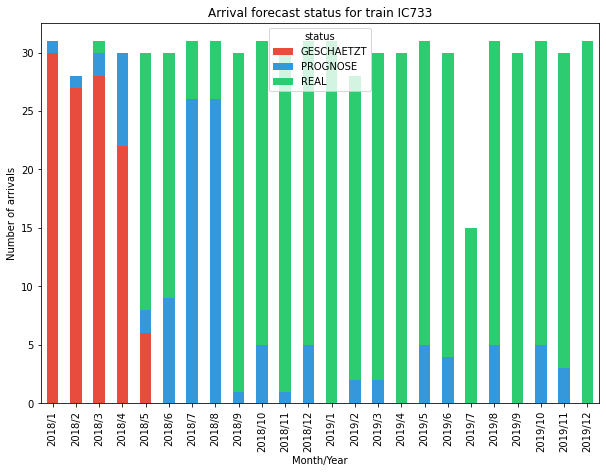

In [182]:
# Create pivot table and plot results using stacked bar chart
pivot_df = df_status733.pivot(index='dateindex', columns='status', values='changes')
ax = pivot_df.plot.bar(stacked=True, color=['#E74C3C', '#3498DB', '#2ECC71'], 
                       figsize=(10,7), xticks=range(0,len(pivot_df.index)))
ax.set_xticklabels(np.array(dateindex.unique()))
plt.title('Arrival forecast status for train IC733')
plt.ylabel('Number of arrivals')
plt.xlabel('Month/Year')
plt.show

ii) Show how the monthly distribution of `AN_PROGNOSE_STATUS` for all the trains that arrived at Lausanne station. Document any anything you observed.

In [168]:
# Count number of statuses for each month for all the trains in Lausanne
query = """
    select 
        AN_PROGNOSE_STATUS as status, 
        count(AN_PROGNOSE_STATUS) as changes, 
        MONTH(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy')))) as month, 
        YEAR(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy')))) as year
    from {0}.sbb_orc
    where HALTESTELLEN_NAME like 'Lausanne' and not(AN_PROGNOSE like '')
    group by 
        AN_PROGNOSE_STATUS, 
        MONTH(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy')))), 
        YEAR(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy'))))
    order by year, month asc
""".format(username)
df_lstatus=pd.read_sql(query, conn)
df_lstatus.head(5)

,status,changes,month,year
0,GESCHAETZT,13208,1,2018
1,PROGNOSE,23,1,2018
2,GESCHAETZT,12017,2,2018
3,PROGNOSE,23,2,2018
4,PROGNOSE,71,3,2018


In [183]:
# Define a dateindex, which represents a month and a year
dateindex =  df_lstatus['year'].astype(str) + '/' + df_lstatus['month'].astype(str)
df_lstatus['dateindex'] = dateindex.map(lambda x: datetime.strptime(x, '%Y/%m'))

<function matplotlib.pyplot.show(*args, **kw)>

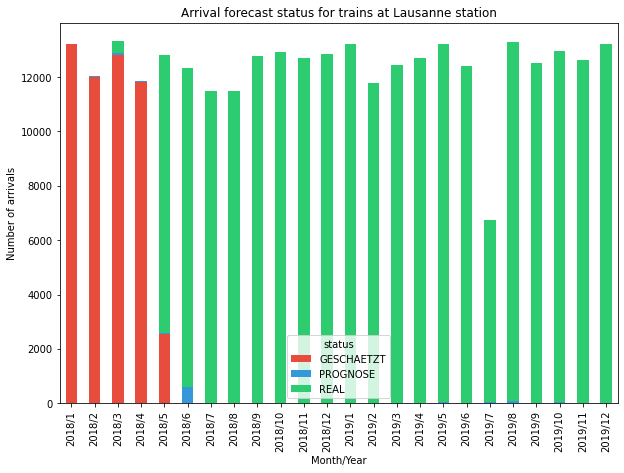

In [185]:
# Create pivot table and plot results using stacked bar chart
pivot_df = df_lstatus.pivot(index='dateindex', columns='status', values='changes')
ax = pivot_df.plot.bar(stacked=True, color=['#E74C3C', '#3498DB', '#2ECC71'], 
                       figsize=(10,7), xticks=range(0,len(pivot_df.index)))
ax.set_xticklabels(np.array(dateindex.unique()))
plt.title('Arrival forecast status for trains at Lausanne station')
plt.ylabel('Number of arrivals')
plt.xlabel('Month/Year')
plt.show

**Observation:** *When we compare the monthly distributions of 2018 and 2019, 2019 has significantly more REAL-status values than 2018, which is good since it's a more effective way of calculating. July has a lot fewer forecasts than the rest of the months and this is because of missing data in July.*

### Question I.d - 20 Points

In this question, use __REAL__ for `AN_PROGNOSE_STATUS` and `AB_PROGNOSE_STATUS`.

i) Display the distribution of delays for the __IC 733__ train at the Lausanne train station. Select the information from the database as a "histogram" with bin size of one minute and plot it in a proper way.

__Note:__ when the train is ahead of schedule, count this as a delay of 0.

In [9]:
# Get departure times of IC 733 for the stop Lausanne
# Calculate the delays and define bins such that we have 1min-bins for each delay
query = """
    with Times as(
        select upper(VERKEHRSMITTEL_TEXT) as stype, 
               unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm') as expected, 
               unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual
        from {0}.sbb_orc
        where 
            VERKEHRSMITTEL_TEXT like 'IC' and 
            HALTESTELLEN_NAME like 'Lausanne' and 
            LINIEN_ID like '733' and 
            AB_PROGNOSE_STATUS like 'REAL'
    )
    select stype, actual - expected as delay, round((actual - expected)/60) as bins
    from Times
    where actual > expected
    order by bins asc
    limit 500
""".format(username)
df_delays733 = pd.read_sql(query, conn)

<function matplotlib.pyplot.show(*args, **kw)>

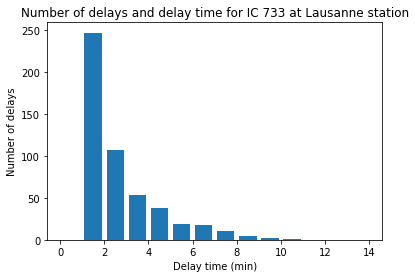

In [40]:
# Show number of delays for the different delay times
population = df_delays733['bins'].tolist()
intpop = [int(x) for x in population]
binn = np.arange(0,max(intpop) + 5,1) 
plt.hist(intpop, binn, histtype = 'bar', rwidth = 0.8)
plt.title('Number of delays and delay time for IC 733 at Lausanne station')
plt.ylabel('Number of delays')
plt.xlabel('Delay time (min)')
plt.show

ii) Compute the 50th and 75th percentiles of delays for IC 702, 704, ..., 728, 730 (15 trains total) at Genève main station. Which trains are the most disrupted? Can you find the tendency and interpret?

In [14]:
# Get departure times for the train tuple IC 702,...,730 at Geneva station
query = """
    with Times2 as(
        select upper(VERKEHRSMITTEL_TEXT) as stype,
               LINIEN_ID as id,
               unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm') as expected, 
               unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual
        from {0}.sbb_orc
        where 
            VERKEHRSMITTEL_TEXT like 'IC' and 
            HALTESTELLEN_NAME like 'Genève' and 
            AB_PROGNOSE_STATUS like 'REAL' and 
            cast(LINIEN_ID as int) >= 702 and 
            cast(LINIEN_ID as int) <= 730 and 
            (cast(LINIEN_ID as int)% 2) == 0
    )
    select id, actual - expected as delay
    from Times2
    where actual > expected
    order by delay asc
    limit 500
""".format(username)
df_delays700s = pd.read_sql(query, conn)
df_delays700s.head(3)

,id,delay
0,730,2
1,716,12
2,708,12


In [41]:
print('50th percentile of delays (in seconds):')
df_delays700s['delay'].quantile(0.5)

50th percentile of delays (in seconds):


39.0

In [43]:
print('75th percentile of delays (in seconds):')
df_delays700s['delay'].quantile(0.75)

75th percentile of delays (in seconds):


42.0

iii) Compute 25th, 50th and 75th percentiles of delays for all trains departing Lausanne gare within each hour and visualize your results. Can you find the tendency and interpret?

*We want to compare what the different percentiles look like for different types of days, that is a weekday vs. a weekend day.*

*We choose the date 20.12.2018 to look at delays on a weekday.*

In [31]:
# Calculate departing delays at Lausanne every hour for 20.12.2018
query = """
    with Times3 as(
        select upper(VERKEHRSMITTEL_TEXT) as stype,
               LINIEN_ID as id,
               unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm') as expected, 
               unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual, 
               HOUR((FROM_UNIXTIME(UNIX_TIMESTAMP(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss')))) as hour
        from {0}.sbb_orc
        where 
            HALTESTELLEN_NAME like 'Lausanne' and 
            AB_PROGNOSE_STATUS like 'REAL' and 
            BETRIEBSTAG like '20.12.2018'
    )
    select stype, id, hour, actual - expected as delay
    from Times3
    where actual > expected
    limit 500
""".format(username)
df_ldelay = pd.read_sql(query, conn)

<function matplotlib.pyplot.show(*args, **kw)>

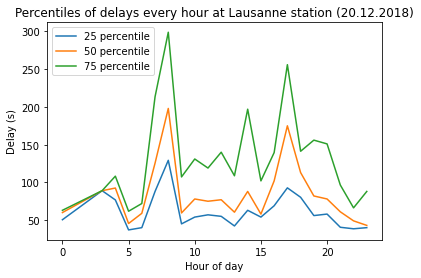

In [32]:
# Calculate the percentiles and plot results
perc_50 = df_ldelay.groupby(['hour'])['delay'].quantile(0.5).reset_index()
perc_25 = df_ldelay.groupby(['hour'])['delay'].quantile(0.25).reset_index()
perc_75 = df_ldelay.groupby(['hour'])['delay'].quantile(0.75).reset_index()

plt.plot(perc_25['hour'], perc_25['delay'], label='25 percentile')
plt.plot(perc_50['hour'], perc_50['delay'], label='50 percentile')
plt.plot(perc_75['hour'], perc_75['delay'], label='75 percentile')
plt.legend()
plt.title('Percentiles of delays every hour at Lausanne station (20.12.2018)')
plt.ylabel('Delay (s)')
plt.xlabel('Hour of day')
plt.show

*We choose the date 04.11.2018 to look at delays on a weekend.*

In [28]:
# Calculate departing delays at Lausanne every hour for 04.11.2018
query = """
    with Times3 as(
        select upper(VERKEHRSMITTEL_TEXT) as stype,
               LINIEN_ID as id,
               unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm') as expected, 
               unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual, 
               HOUR((FROM_UNIXTIME(UNIX_TIMESTAMP(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss')))) as hour
        from {0}.sbb_orc
        where 
            HALTESTELLEN_NAME like 'Lausanne' and 
            AB_PROGNOSE_STATUS like 'REAL' and 
            BETRIEBSTAG like '04.11.2018'
    )
    select stype, id, hour, actual - expected as delay
    from Times3
    where actual > expected
    limit 500
""".format(username)
df_ldelay = pd.read_sql(query, conn)

<function matplotlib.pyplot.show(*args, **kw)>

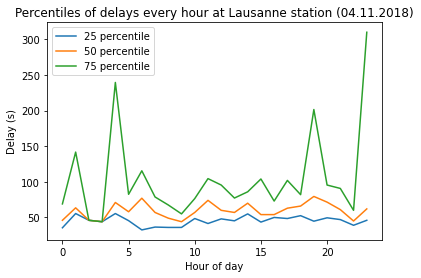

In [30]:
# Calculate the percentiles and plot results
perc_50 = df_ldelay.groupby(['hour'])['delay'].quantile(0.5).reset_index()
perc_25 = df_ldelay.groupby(['hour'])['delay'].quantile(0.25).reset_index()
perc_75 = df_ldelay.groupby(['hour'])['delay'].quantile(0.75).reset_index()

plt.plot(perc_25['hour'], perc_25['delay'], label='25 percentile')
plt.plot(perc_50['hour'], perc_50['delay'], label='50 percentile')
plt.plot(perc_75['hour'], perc_75['delay'], label='75 percentile')
plt.legend()
plt.title('Percentiles of delays every hour at Lausanne station (04.11.2018)')
plt.ylabel('Delay (s)')
plt.xlabel('Hour of day')
plt.show

iv) Did you notice something "strange"? Can you try to find the reasons behind that? Feel free to check it out from different perspectives.

*During a normal work day, we see peaks in delays during rush hours, in the morning as well as in the evening. On a weekend, there is no clear pattern of the delays. However, we can see that there is more activity during the night hours on a weekend. Results that all seem to make sense.*

### Question I.f - 15 Points

If the departure time of one train is delayed, can it catch up with the schedule at a later station? Select __at least 2 trains from Genève (main station) to Lausanne gare__ as examples. Think about what kind of trains you want to select, direct or indirect (having stops in between), at rush hour or in midnight? Use HiveQL to select relevant data and show the results with a proper plot of arrival delay at Lausanne versus departure delay at Genève. Document and discuss your findings.

__Note__: you can write some helper functions to generate the query for you.

*We start looking at how the departure and arrival times are connected, from Geneva to Lausanne on a weekday (04/11/2019). We choose to look at all IC-trains, direct and indirect.*

In [ ]:
# Drop the table if it exists
query = """
    drop table if exists {0}.sbb_geneve
""".format(username)
cur.execute(query)

# Create a table for IC trains in Geneva for a week day (e.g.04/11/2019)
query = """
    create table {0}.sbb_geneve
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where HALTESTELLEN_NAME like 'Genève' 
        and BETRIEBSTAG like '04.11.2019'
""".format(username)
cur.execute(query)

# Drop the table if it exists
query = """
    drop table if exists {0}.sbb_Lausanne
""".format(username)
cur.execute(query)

# Create a table for IC trains in Lausanne for a week day (e.g.04/11/2019)
query = """
    create table {0}.sbb_Lausanne
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where HALTESTELLEN_NAME like 'Lausanne' 
        and BETRIEBSTAG like '04.11.2019'
""".format(username)
cur.execute(query)

Text(0, 0.5, 'Arrival delay to Lausanne (s)')

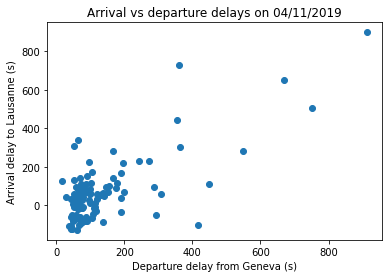

In [50]:
# Select relevant parameters and do an outer join with the train ID's
# Filter for trains from Geneva to Lausanne by the prognosed departure/arrival times 
query = """
    with times4 as (
    select 
        upper(g.VERKEHRSMITTEL_TEXT) as trains, 
        g.LINIEN_ID as id, 
        unix_timestamp(g.AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as departure_time_g,
        unix_timestamp(g.ABFAHRTSZEIT, 'dd.MM.yyy HH:mm') as expected_departure_g,
        unix_timestamp(l.AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as arrival_time_l, 
        unix_timestamp(l.ANKUNFTSZEIT, 'dd.MM.yyy HH:mm') as expected_arrival_l
    from {0}.sbb_geneve g FULL OUTER JOIN {0}.sbb_Lausanne l ON (g.LINIEN_ID = l.LINIEN_ID)
    where 
        unix_timestamp(l.AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') > 0 and 
        unix_timestamp(g.AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') > 0 and 
        unix_timestamp(l.AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') > unix_timestamp(g.AB_PROGNOSE, 'dd.MM.yyy HH:mm')
    )
    select trains, id, 
        departure_time_g - expected_departure_g as departure_delay, 
        arrival_time_l - expected_arrival_l as arrival_delay
    from times4
    where departure_time_g > expected_departure_g
""".format(username)
df_trains = pd.read_sql(query, conn)

plt.scatter(df_trains['departure_delay'], df_trains['arrival_delay'])
plt.title('Arrival vs departure delays on 04/11/2019')
plt.xlabel('Departure delay from Geneva (s)')
plt.ylabel('Arrival delay to Lausanne (s)')

*We continue looking at how the departure and arrival times are connected, from Geneva to Lausanne on a weekday (04/11/2019) during rush hour (7am-10am). We choose to look at all IC-trains, direct and indirect.*

Text(0, 0.5, 'Arrival delay to Lausanne (s)')

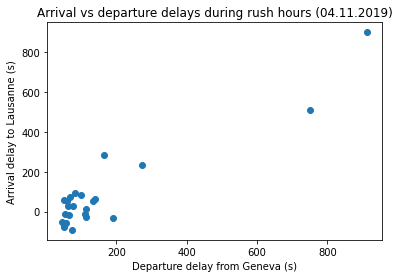

In [51]:
# Select relevant parameters from Geneva table and do an outer join with the train ID's
# Filter for trains Geneva to Lausanne by the prognosed departure/arrival times and choose rush hour
query = """
    with times4 as (
    select 
        upper(g.VERKEHRSMITTEL_TEXT) as trains, 
        g.LINIEN_ID as id, 
        unix_timestamp(g.AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as departure_time_g,
        unix_timestamp(g.ABFAHRTSZEIT, 'dd.MM.yyy HH:mm') as expected_departure_g,
        unix_timestamp(l.AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as arrival_time_l, 
        unix_timestamp(l.ANKUNFTSZEIT, 'dd.MM.yyy HH:mm') as expected_arrival_l
    from {0}.sbb_geneve g FULL OUTER JOIN {0}.sbb_Lausanne l ON (g.LINIEN_ID = l.LINIEN_ID)
    where 
        unix_timestamp(l.AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') > 0 and 
        unix_timestamp(g.AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') > 0 and 
        unix_timestamp(l.AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') > unix_timestamp(g.AB_PROGNOSE, 'dd.MM.yyy HH:mm') and 
        HOUR((FROM_UNIXTIME(UNIX_TIMESTAMP(g.AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss')))) >= 7 and
        HOUR((FROM_UNIXTIME(UNIX_TIMESTAMP(g.AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss')))) <= 10
    )
    select trains, id, 
        departure_time_g - expected_departure_g as departure_delay, 
        arrival_time_l - expected_arrival_l as arrival_delay
    from times4
    where departure_time_g > expected_departure_g
""".format(username)
rush_hour = pd.read_sql(query, conn)

plt.scatter(rush_hour['departure_delay'], rush_hour['arrival_delay'])
plt.title('Arrival vs departure delays during rush hours (04.11.2019)')
plt.xlabel('Departure delay from Geneva (s)')
plt.ylabel('Arrival delay to Lausanne (s)')

*We end by looking at how the departure and arrival times are connected, from Geneva to Lausanne on a weekday (04/11/2019) during non-rush hour (8pm-11pm). We choose to look at all types of trains, direct and indirect.*

Text(0, 0.5, 'Arrival delay to Lausanne (s)')

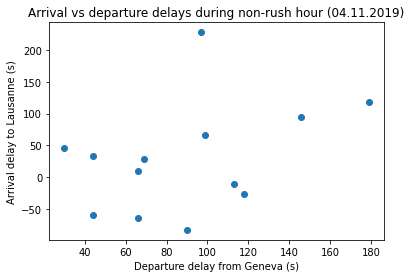

In [52]:
# Select relevant parameters from Geneva table and do an outer join with the train ID's
# Filter for trains Geneva to Lausanne by the prognosed departure/arrival times and choose non-rush hour
query = """
    with times4 as (
    select 
        upper(g.VERKEHRSMITTEL_TEXT) as trains, 
        g.LINIEN_ID as id, 
        unix_timestamp(g.AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as departure_time_g,
        unix_timestamp(g.ABFAHRTSZEIT, 'dd.MM.yyy HH:mm') as expected_departure_g,
        unix_timestamp(l.AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as arrival_time_l, 
        unix_timestamp(l.ANKUNFTSZEIT, 'dd.MM.yyy HH:mm') as expected_arrival_l
    from {0}.sbb_geneve g FULL OUTER JOIN {0}.sbb_Lausanne l ON (g.LINIEN_ID = l.LINIEN_ID)
    where 
        unix_timestamp(l.AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') > 0 and 
        unix_timestamp(g.AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') > 0 and 
        unix_timestamp(l.AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') > unix_timestamp(g.AB_PROGNOSE, 'dd.MM.yyy HH:mm') and 
        HOUR((FROM_UNIXTIME(UNIX_TIMESTAMP(g.AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss')))) >= 20 and
        HOUR((FROM_UNIXTIME(UNIX_TIMESTAMP(g.AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss')))) <= 23
    )
    select trains, id, 
        departure_time_g - expected_departure_g as departure_delay, 
        arrival_time_l - expected_arrival_l as arrival_delay
    from times4
    where departure_time_g > expected_departure_g
""".format(username)
midnight = pd.read_sql(query, conn)

plt.scatter(midnight['departure_delay'], midnight['arrival_delay'])
plt.title('Arrival vs departure delays during non-rush hour (04.11.2019)')
plt.xlabel('Departure delay from Geneva (s)')
plt.ylabel('Arrival delay to Lausanne (s)')

**Observations:**
1. *There exists a linear relationship between the departure delay and the arrival delay. The higher the departure delay, the higher the arrival delay, and vice versa.*
2. *The hour of the day had no clear effect on the delay.*
3. *The trains that were delayed for less than ~90 seconds are more likely to catch up at a later stop.*
4. *Negative values in the last plot means that the train arrived before the scheduled time.*

*We tried to plot the delays of only two trains, for all days, but no pattern could be observed. Therefore, we chose to select all trains and plot the results for just one day (as seen above).*